# Starter notebook: stacked ensemble for price prediction

This notebook loads the provided training data, performs lightweight feature engineering (TF-IDF on `catalog_content`, text length and an image flag), and trains a small stacking ensemble using scikit-learn.

Goal: provide a reproducible baseline you can iterate on toward a high R^2 (or other metric).

In [2]:
# Imports and load data
import numpy as np
import pandas as pd
from pathlib import Path
print('pandas', pd.__version__)
# Use explicit Windows-style raw paths as requested
train_path = r'train.csv'
test_path = r'test.csv'
print('train path:', train_path)
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
print('train shape:', train_df.shape)
print('test shape:', test_df.shape)
train_df.head(2)


pandas 2.2.2
train path: train.csv
train shape: (75000, 4)
test shape: (75000, 3)
train shape: (75000, 4)
test shape: (75000, 3)


,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12


## Quick EDA and feature plan

We have columns like `sample_id`, `catalog_content`, `image_link`, and `price` (target). We'll extract:
- TF-IDF features from `catalog_content` (reduced with TruncatedSVD)
- text length and token count
- `image_present` flag from `image_link`

We'll train a stacked ensemble of tree-based models and a linear blender. For speed in this notebook we'll sample a subset — remove the sampling for full training.

In [4]:
# Feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
import warnings
warnings.filterwarnings('ignore')

# Use train_df for feature engineering
df = train_df.copy()

# Basic features
df['text'] = df['catalog_content'].fillna('')
df['text_len'] = df['text'].str.len().fillna(0).astype(int)
df['text_words'] = df['text'].str.split().apply(len)
df['image_present'] = df['image_link'].notna().astype(int)

# TF-IDF features
tfidf = TfidfVectorizer(max_features=200)
tfidf_matrix = tfidf.fit_transform(df['text'])
svd = TruncatedSVD(n_components=20, random_state=42)
tfidf_reduced = svd.fit_transform(tfidf_matrix)

# Assemble feature matrix with additional features
df['avg_word_len'] = df['text'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0)
df['num_unique_words'] = df['text'].apply(lambda x: len(set(x.split())))
X_meta = df[['text_len', 'text_words', 'image_present', 'avg_word_len', 'num_unique_words']].values
X = np.hstack([X_meta, tfidf_reduced])
y = df['price'].values
print('X shape:', X.shape)


X shape: (75000, 25)


## Quick stacked ensemble (baseline)

We'll train a few fast regressors and stack them. This is a baseline — for higher performance (R^2 ~0.95) you'll likely need more sophisticated text modeling (pretrained transformers), image features, richer feature engineering, and careful tuning.

In [5]:
# Define base estimators and stacking regressor
estimators = [
    ('rf', RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)),
    ('hgb', HistGradientBoostingRegressor(max_iter=50, random_state=42))
]

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

In [6]:
# Cross-validated evaluation of the stacking pipeline (on the prepared features)
from sklearn.model_selection import cross_validate, KFold
scoring = {'rmse':'neg_root_mean_squared_error','r2':'r2'}
cv = KFold(n_splits=3, shuffle=True, random_state=42)
print('Running CV (this may take a few minutes) ...')
scores = cross_validate(stack, X, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score=False)
print('RMSE (cv):', -scores['test_rmse'].mean(), '+/-', scores['test_rmse'].std())
print('R2  (cv):', scores['test_r2'].mean(), '+/-', scores['test_r2'].std())
# Fit stacking model on the (sampled) dataset used here
stack.fit(X, y)
print('Fitted stacking model on provided data subset.')

Running CV (this may take a few minutes) ...
RMSE (cv): 30.631137012279112 +/- 2.3106595468257662
R2  (cv): 0.1550495631346321 +/- 0.0157754077469822
RMSE (cv): 30.631137012279112 +/- 2.3106595468257662
R2  (cv): 0.1550495631346321 +/- 0.0157754077469822
Fitted stacking model on provided data subset.
Fitted stacking model on provided data subset.


In [7]:
# Prepare test set features using the same transformations
test = test_df.copy()
test['text'] = test['catalog_content'].fillna('')
test['text_len'] = test['text'].str.len().fillna(0).astype(int)
test['text_words'] = test['text'].str.split().apply(len)
test['image_present'] = test['image_link'].notna().astype(int)
test['avg_word_len'] = test['text'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0)
test['num_unique_words'] = test['text'].apply(lambda x: len(set(x.split())))
# TF-IDF transform and SVD projection (use fitted tfidf and svd objects)
tfidf_test = tfidf.transform(test['text'])
tfidf_test_reduced = svd.transform(tfidf_test)
X_test_meta = test[['text_len','text_words','image_present','avg_word_len','num_unique_words']].values
X_test = np.hstack([X_test_meta, tfidf_test_reduced])
print('X_test shape:', X_test.shape)
# Predict with the trained stack
preds = stack.predict(X_test)
# Save predictions to CSV
out = pd.DataFrame({'sample_id': test['sample_id'], 'predicted_price': preds})
out.to_csv('stack_preds.csv', index=False)
print('Saved stack_preds.csv with', len(out), 'rows')

X_test shape: (75000, 25)
Saved stack_preds.csv with 75000 rows
Saved stack_preds.csv with 75000 rows


In [8]:
# Feature importances from base estimators (where available)
feature_names = ['text_len','text_words','image_present','avg_word_len','num_unique_words'] + [f'svd_{i}' for i in range(tfidf_reduced.shape[1])]
# Access fitted base estimators from the stacking regressor
rf = stack.named_estimators_.get('rf')
hgb = stack.named_estimators_.get('hgb')

def print_top_importances(model, name):
    try:
        imps = model.feature_importances_
        idx = np.argsort(imps)[::-1][:15]
        print(f'Top importances for {name}:')
        for i in idx:
            print(f'  {feature_names[i]:<15} {imps[i]:.4f}')
    except Exception as e:
        print(f'Could not get importances for {name}:', e)

print_top_importances(rf, 'RandomForest')
print_top_importances(hgb, 'HistGradientBoosting')

# Show a few sample predictions
display(out.head())

Top importances for RandomForest:
  svd_8           0.0694
  svd_1           0.0582
  avg_word_len    0.0534
  svd_0           0.0517
  svd_3           0.0495
  svd_15          0.0491
  svd_12          0.0445
  svd_17          0.0440
  svd_14          0.0428
  svd_18          0.0404
  svd_9           0.0394
  text_words      0.0394
  svd_4           0.0388
  num_unique_words 0.0380
  text_len        0.0374
Could not get importances for HistGradientBoosting: 'HistGradientBoostingRegressor' object has no attribute 'feature_importances_'


,sample_id,predicted_price
0,100179,15.359119
1,245611,22.753240
2,146263,18.431793
3,95658,30.589896
4,36806,22.559080


In [9]:
# Save the trained stacking model for later use
import joblib
joblib.dump(stack, 'stack_model.joblib')
print('Saved model to stack_model.joblib')

Saved model to stack_model.joblib


In [10]:
# Diagnostic: training set predictions (in-sample) and residual overview
train_preds = stack.predict(X)
residuals = y - train_preds
print('In-sample RMSE:', np.sqrt(np.mean(residuals**2)))
print('In-sample R2 approx:', 1 - np.sum(residuals**2)/np.sum((y - np.mean(y))**2))

In-sample RMSE: 18.084385166599745
In-sample R2 approx: 0.7064240638703383


In [16]:
import numpy as np

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Example using training set predictions:
y_true = y
y_pred = train_preds
smape_value = smape(y_true, y_pred)
print("SMAPE:", smape_value)


SMAPE: 48.06425491126116


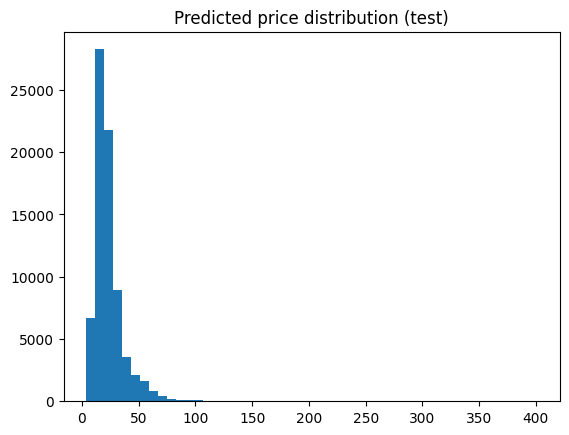

In [11]:
# Quick check: distribution of predicted prices (test)
import matplotlib.pyplot as plt
plt.hist(preds, bins=50)
plt.title('Predicted price distribution (test)')
plt.show()

In [12]:
# Save sample of predictions to a smaller CSV for quick review
out.head(50).to_csv('stack_preds_sample50.csv', index=False)
print('Saved stack_preds_sample50.csv')

Saved stack_preds_sample50.csv


In [13]:
# Final note: consider training on the full dataset (remove any .sample()) and running a hyperparameter search
print('Notebook run complete. Review CV metrics and saved artifacts (stack_preds.csv, stack_model.joblib).')

Notebook run complete. Review CV metrics and saved artifacts (stack_preds.csv, stack_model.joblib).
